In [28]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.enable_eager_execution()


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pickle
import pandas as pd

from collections import Counter
from itertools import chain
from itertools import dropwhile

In [29]:
tf.executing_eagerly()


True

In [30]:
tf.test.is_gpu_available()

True

In [31]:
MAX_SEQUENCE_LENGTH=30
path_to_file1 = 'combinedChatQuestionAnswerFormatDelearCust'
path_to_file2 = 'combinedChatQuestionAnswerFormatCustDelear'
path_to_inp_lang = 'inp_lang'
path_to_targ_lang = 'targ_lang'
WORDS_FREQ_THRESHOLD = 2

In [32]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [33]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

     #Remove URLS
    w = re.sub(r"http\S+", "", w)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [34]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [35]:
def create_dataset(paths, num_examples):
    questions = []
    answers = []
    for path in paths:
        lines = []
        with open (path, 'rb') as fp:
            lines = pickle.load(fp)
        for i in range(0, len(lines), 2):
            questions.append(preprocess_sentence(lines[i]))
            answers.append(preprocess_sentence(lines[i+1]))
        
    return (questions, answers)

In [36]:
def getWordsWithFreqLessThanK(wordCounter, k):
    
    cnt = 0
    for word in wordCounter:
        if wordCounter[word] < k:
            cnt += 1
            #print(word, wordCounter[word])
            
    print("total ", cnt, " out of ", len(wordCounter))

In [37]:
def removeWordsWithFreqLessThanK(wordCounter, k):
    
    cnt = 0
    for word in wordCounter:
        if wordCounter[word] < k:
            cnt += 1
            #del wordCounter[word]
            #print(word, wordCounter[word])
            
    print("removing ", cnt, " out of ", len(wordCounter), len(wordCounter)- cnt)
    
    for key, count in dropwhile(lambda key_count: key_count[1] >= k, wordCounter.most_common()):
        del wordCounter[key]
    
    print("final count: ", len(wordCounter))

In [38]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    self.wordCounter = {}
    
    self.create_index()
    
  def create_index(self):
#     for phrase in self.lang:
#       self.vocab.update(phrase.split(' '))
    
#     self.vocab = sorted(self.vocab)
    
    self.wordCounter = Counter(chain.from_iterable(map(lambda x: x.split(' '), self.lang)))
    removeWordsWithFreqLessThanK(self.wordCounter, WORDS_FREQ_THRESHOLD)
    
    self.vocab = sorted(set(list(self.wordCounter.keys())))
    self.word2idx['<pad>'] = 0
    self.word2idx['<unk>'] = 1
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 2
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [12]:
# pairs = create_dataset([path_to_file1,path_to_file2],0)
# inp_lang = LanguageIndex(pairs[0])
# targ_lang = LanguageIndex(pairs[1])

removing  5078  out of  9701 4623
final count:  4623
removing  5152  out of  9870 4718
final count:  4718


In [39]:
def pickleLangobj(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

In [11]:
def getLangObj(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
        return obj

In [ ]:
# inp_lang.wordCounter

In [ ]:
# from collections import Counter
# from itertools import chain

# list1=['hello apple','hello egg','hello2 apple','hello2 banana','hello3 egg','hello3 apple']
# counts = Counter(chain.from_iterable(map(lambda x: x.split(' '), list1)))
# print(counts)

In [40]:
def max_length(tensor):
    #return max(len(t) for t in tensor)
    return MAX_SEQUENCE_LENGTH

def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(pairs[0])
    targ_lang = LanguageIndex(pairs[1])
    
    pickleLangobj(path_to_inp_lang,inp_lang)
    pickleLangobj(path_to_targ_lang,targ_lang)

    #print(inp_lang.word2idx[s] for s in pairs[0][0])
    # Vectorize the input and target languages
    
    # Spanish sentences
    #input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for sp in pairs[0]]
    input_tensor = []
    for sp in pairs[0]:
        wordIds = []
        for s in sp.split(' '):
            if (s in inp_lang.word2idx):
                wordIds.append(inp_lang.word2idx[s])
            else:
                wordIds.append(inp_lang.word2idx['<unk>'])
        input_tensor.append(wordIds)
    
    # English sentences
    #target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en in pairs[1]]
    target_tensor = []
    for sp in pairs[1]:
        wordIds = []
        for s in sp.split(' '):
            if (s in targ_lang.word2idx):
                wordIds.append(targ_lang.word2idx[s])
            else:
                wordIds.append(targ_lang.word2idx['<unk>'])
        target_tensor.append(wordIds)
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [41]:

# Try experimenting with the size of that dataset
num_examples = None
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset([path_to_file1,path_to_file2], num_examples)

removing  5078  out of  9701 4623
final count:  4623
removing  5152  out of  9870 4718
final count:  4718


In [ ]:
inp_lang.wordCounter

In [ ]:
target_tensor

In [43]:

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(25641, 25641, 6411, 6411)

In [44]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32#64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 512 #1024
MAX_GRADIENT_VAL = 10.0
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [46]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(32), Dimension(30)]),
 TensorShape([Dimension(32), Dimension(30)]))

## Technical jargon H-> Hidden state1, C-> Hidden state2, both hidden states of LSTM

### LSTM layer notes
- We declare the LSTM layers to process the input sentences. Layer has the "units"(this is units parameter in tf.keras.layers.CuDNNLSTM) number of LSTM cells chained. 
- This layer takes inputs of shape (batch size, max sequence length, embeddings dimensions). 
- This same layer is unfolded max sequence length times during the training. Same layer is used during each time step, the only difference in each time step is, it takes the input from previous time step and current input. This is the recurrent part and weights are shared accorss the training.  
- For Unidirectinal:
  - It returns output, hiddenstate1(H), hiddenstate2(C).
  - Hidden states have shape -> (batchsize, LSTM Units).
  - If return_sequences is set, output has the shape (batch_size, max_length, LSTM units), else it returns (batchsize, encoder units) only last step output.
- For Bidirectinal :
  - It returns both forwad and backward hidden states and concatinated output.OP, forward H, forward C, backward H, backward C.
  - Hidden states have shape -> (batchsize, LSTM Units).
  - If return_sequences is set, output has the shape (batch_size, max_length, 2xLSTM units), else it returns (batchsize, 2xLSTM units) only last step output.
  - The x2 factor in return sizes corresponds to the bi-directinal cells.
  

In [47]:
def BiLSTM(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    lstm = tf.keras.layers.CuDNNLSTM(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    
#     lstm = tf.nn.rnn_cell.DropoutWrapper(lstm,input_keep_prob=0.8,
# output_keep_prob=0.8,
# state_keep_prob=1.0)

    return tf.keras.layers.Bidirectional(lstm)
  else:
    return "No GPU!!!"    
    #return tf.keras.layers.GRU(units, 
    #                           return_sequences=True, 
    ##                           return_state=True, 
    #                           recurrent_activation='sigmoid', 
     #                          recurrent_initializer='glorot_uniform')

In [48]:
def LSTM(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
  if tf.test.is_gpu_available():
    lstm = tf.keras.layers.CuDNNLSTM(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
#     lstm = tf.nn.rnn_cell.DropoutWrapper(lstm,input_keep_prob=0.8,
#             output_keep_prob=0.8,
#             state_keep_prob=1.0)
    
    return lstm
  else:
    return "No GPU!!!"    
    #return tf.keras.layers.GRU(units, 
    #                           return_sequences=True, 
    ##                           return_state=True, 
    #                           recurrent_activation='sigmoid', 
     #                          recurrent_initializer='glorot_uniform')

In [56]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.bilstm = BiLSTM(self.enc_units)
        
    def call(self, x, hidden):
        #X shape is [batchsize, maxSeqLen]
        x = self.embedding(x)
        #X shape is [batchsize, maxSeqLen, embedding dimension]
        output, fw_H, fw_C, bw_H, bw_C = self.bilstm(x)
        #output, fw_H, fw_C, bw_H, bw_C = self.bilstm(x, initial_state = hidden)
        
        #Output shape is [batchsize, maxSeqLen, 2*LSTM Units]
        #fw or bw hidden state shape is [batchsize, LSTM Units]
        
        ## We concatinate these states because in decoder we can only have a unidirectinal layer. This is because in 
        ## decoder we dont the future words.
        final_H = tf.concat((fw_H, bw_H), 1)
        #After concatenation hidden state shape is [batchsize, 2*LSTM Units]
        final_C = tf.concat((fw_C, bw_C), 1)
        return output, final_H, final_C
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [92]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units*2
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = LSTM(self.dec_units)
        ## We use this layer to pass the LSTM output to get the logits for each word, hence the dimension - vocab_size. 
        ## These logits are for each word being the next word in output sentence.
        ## We pass this fc out to error function which takes logits as input.
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.W3 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, dec_H, dec_C, enc_output):
        # enc_output shape == (batch_size, max_length, 2*encoder units)
        
        
        # hidden shape == (batch_size, decoder units)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size or decoder units)
        # we are doing this to perform addition to calculate the score
        dec_H_time_axis = tf.expand_dims(dec_H, 1)
        dec_C_time_axis = tf.expand_dims(dec_C, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H) +FC(C)) to self.V
        # The out put of a lstm layer is not a softmax(not logits, so pass them through dense layers)
        # and get the Logits and then pass to a dense layer.
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(dec_H_time_axis)+ self.W3(dec_C_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, H, C = self.lstm(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, H, C, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [93]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [94]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

In [95]:
checkpoint_dir = 'D:\\training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [96]:
EPOCHS = 35

startEpoch = 0

try:
    with open(checkpoint_dir+'\\epochNum', 'rb') as f:
        startEpoch = pickle.load(f)
    print('starting with epoch', startEpoch)
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except:
    print('start epoch not found')
    
for epoch in range(startEpoch, EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden_H, enc_hidden_C = encoder(inp, hidden)
            
            dec_hidden_H = enc_hidden_H
            dec_hidden_C = enc_hidden_C
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden_H, dec_hidden_C, _ = decoder(dec_input, dec_hidden_H, dec_hidden_C, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        ## Tapes together all the variables for which we needs to compute the gradients. Here embeddings, dense layers and 
        ## LSTM's weights will be taped together for gradient calculations.
        gradients = tape.gradient(loss, variables)
        
        ## This is to clip the gradients. We might run into the exploding gradients problem while traing the model.
        ## To avoid this we use clipping.
        gradients, _ = tf.clip_by_global_norm(gradients, MAX_GRADIENT_VAL)

        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        with open(checkpoint_dir+'\\epochNum', 'wb') as f:
            pickle.dump(epoch+1, f)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

starting with epoch 12
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,), dtype=int32)
shape of score tf.Tensor([32 30  1], shape=(3,)

KeyboardInterrupt: 

In [ ]:
# def resumeTraining(dataset):
    
#     checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#     EPOCHS = 30
#     for epoch in range(EPOCHS):
#         start = time.time()

#         hidden = encoder.initialize_hidden_state()
#         total_loss = 0

#         for (batch, (inp, targ)) in enumerate(dataset):
#             loss = 0

#             with tf.GradientTape() as tape:
#                 enc_output, enc_hidden_H, enc_hidden_C = encoder(inp, hidden)

#                 dec_hidden_H = enc_hidden_H
#                 dec_hidden_C = enc_hidden_C

#                 dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       

#                 # Teacher forcing - feeding the target as the next input
#                 for t in range(1, targ.shape[1]):
#                     # passing enc_output to the decoder
#                     predictions, dec_hidden_H, dec_hidden_C, _ = decoder(dec_input, dec_hidden_H, dec_hidden_C, enc_output)

#                     loss += loss_function(targ[:, t], predictions)

#                     # using teacher forcing
#                     dec_input = tf.expand_dims(targ[:, t], 1)

#             batch_loss = (loss / int(targ.shape[1]))

#             total_loss += batch_loss

#             variables = encoder.variables + decoder.variables

#             gradients = tape.gradient(loss, variables)

#             gradients, _ = tf.clip_by_global_norm(gradients, MAX_GRADIENT_VAL)

#             optimizer.apply_gradients(zip(gradients, variables))

#             if batch % 100 == 0:
#                 print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
#                                                              batch,
#                                                              batch_loss.numpy()))
#         # saving (checkpoint) the model every 2 epochs
#         if (epoch + 1) % 2 == 0:
#           checkpoint.save(file_prefix = checkpoint_prefix)

#         print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                             total_loss / N_BATCH))
#         print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
resumeTraining(dataset)

In [40]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)
    
    
    #inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = []
    for i in sentence.split(' '):
        if(i in inp_lang.word2idx):
            inputs.append(inp_lang.word2idx[i])
        else:
            inputs.append(inp_lang.word2idx['<unk>'])
    
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_output, enc_hidden_H, enc_hidden_C = encoder(inputs, hidden)
    dec_hidden_H = enc_hidden_H
    dec_hidden_C = enc_hidden_C

    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden_H, dec_hidden_C, attention_weights = decoder(dec_input, dec_hidden_H, dec_hidden_C, enc_output)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [37]:

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [38]:

def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [34]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> welcome to gillespie ford , how may we assist you today ? <end>
Predicted translation: i need to make in appointment for a ford f or f i m not sure where to send it <end> 


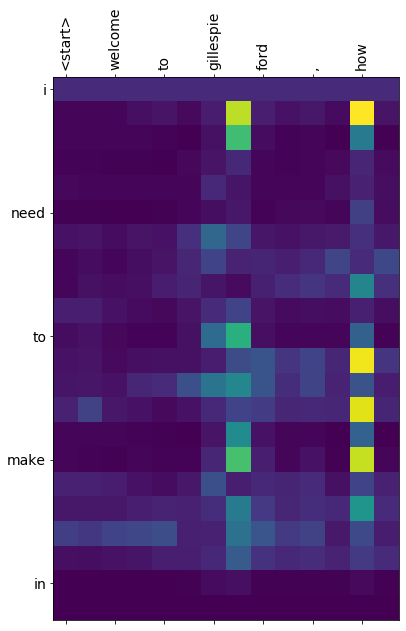

In [41]:
translate(u'welcome to gillespie ford, how may we assist you today?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> would you like to get an appraisal value of your trade online <end>
Predicted translation: sure <end> 


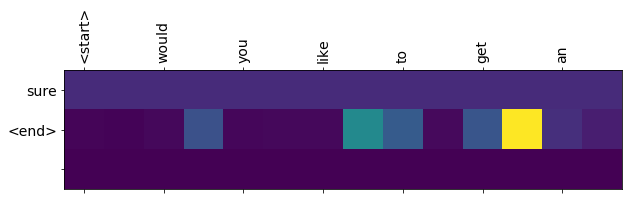

In [42]:
translate(u'would you like to get an appraisal value of your trade online', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> i havent have one but i want a mustang <end>
Predicted translation: let s get you information on that . may i have your first and last name , please ? <end> 


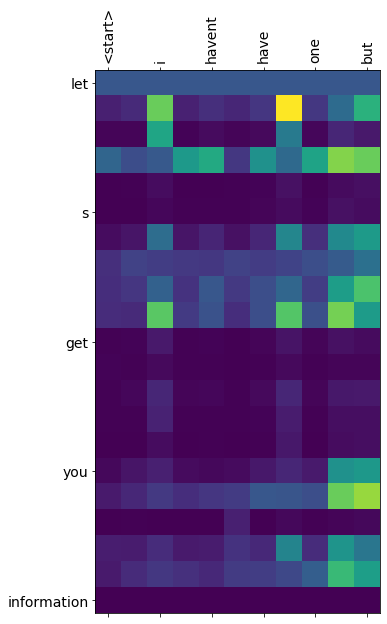

In [43]:
translate(u'i havent have one but i want a mustang', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> thanks , catherine . may i also have your number as an alternative contact ? <end>
Predicted translation: no sorry i will call you . i did this before and i just kept getting to many calls <end> 


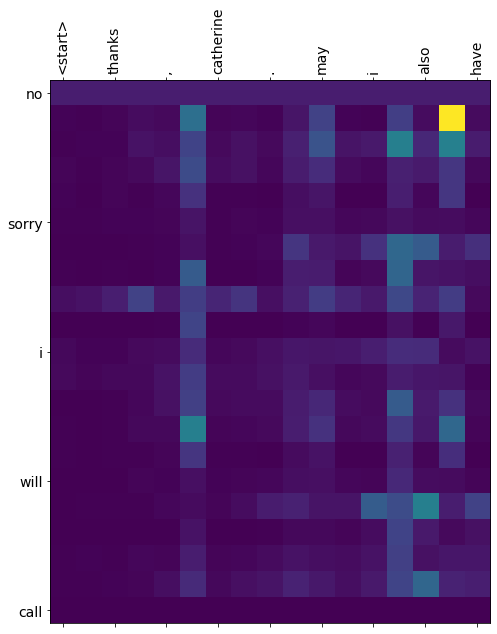

In [44]:
translate(u'thanks, catherine. may i also have your number as an alternative contact?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> welcome to gillespie ford , how may we assist you today ? <end>
Predicted translation: i need to make in appointment for a ford f or f i m not sure where to send it <end> 


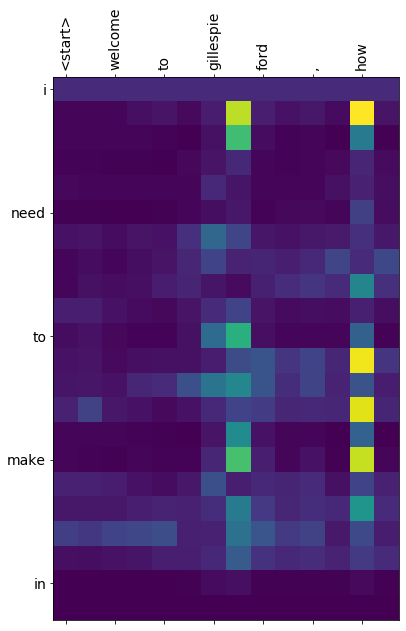

In [45]:
translate(u'Welcome to Gillespie Ford, how may we assist you today?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> interested in a impala do you have any ? <end>
Predicted translation: let s get you information on that . <end> 


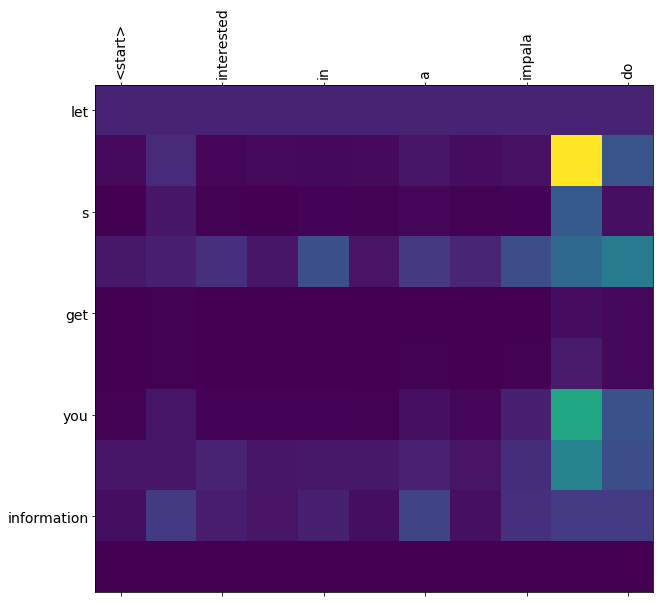

In [46]:
translate(u'Interested in a impala Do you have any?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> i am looking for anything good on gas ? <end>
Predicted translation: would you like to fill out the form to have this confirmed from the right place to help of that . <end> 


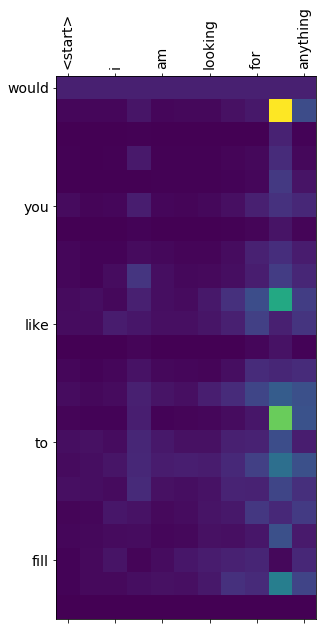

In [47]:
translate(u'I am looking for anything good on gas?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> looking for ford red cars <end>
Predicted translation: let s get you started . may i know who i am chatting with ? <end> 


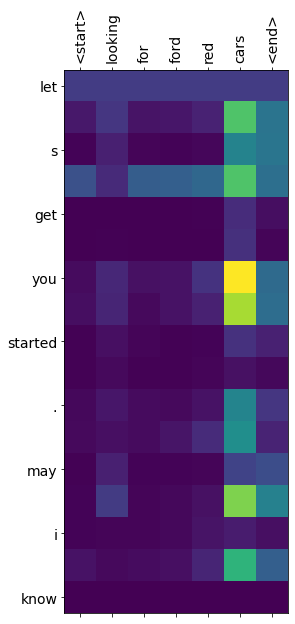

In [48]:
translate(u'looking for ford red cars', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> but my credit is bad and i am little worried <end>
Predicted translation: you can find out the form to find you in this with your trade in . your name and a good low mileage charged at our finance department get back 


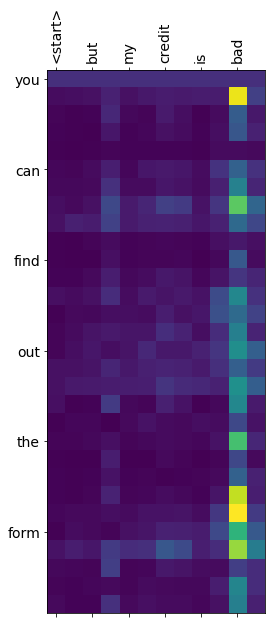

In [49]:
translate(u'But my credit is bad and I am little worried', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start> vineel gmail . com <end>
Predicted translation: thanks , brad . may i have your number as an alternative ? <end> 


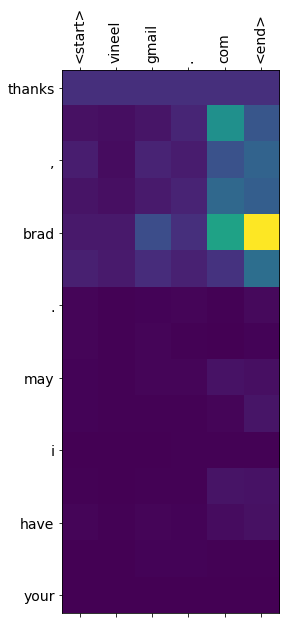

In [51]:
translate(u'vineel@gmail.com', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)